In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import csv
import math
import collections
import pandas as pd

from scipy.optimize import minimize
import sklearn

from sklearn.model_selection import train_test_split


In [2]:
def softmax(x):
    if x.ndim==1:
               #print("1D data case")
               
            return np.exp(x)/ np.sum(np.exp(x))
    else:
        #print("ND data case")
        
        #print("x dim",x.shape)
        #print("x",x)
        #print("result",np.exp(x)/ np.sum(np.exp(x) , axis=1).reshape(-1,1))
        return np.exp(x)/ np.sum(np.exp(x) , axis=1).reshape(-1,1)
#print(softmax([2, 3, 5, 6]))

In [3]:
#this function works when class are mapped to integers starting from class 1
def one_hot_encoding(y):
    y_unique=list(np.unique(y))
     
    #print(y_unique)
    encoding=np.zeros((len(y),len(y_unique)))
    #print(encoding)
    
    for i in range(len(y)):
        encoding[i][int(y[i]-1)]=1
    return encoding
    
    

In [4]:
def get_softmax(x,weights,y_unique):
        predicts = np.dot(x, weights.T).reshape(-1,len(y_unique))
        
        return softmax(predicts)


In [5]:
#this function works when class are mapped to integers starting from class 1

def predict(x,weights,y_unique):
    probs = get_softmax(x,weights,y_unique)
    
    #print(probs)
    
    #print(np.argmax(probs, axis=1)+1)
    #print(np.sum(probs_, axis = 1)) =1 softmax probability space
  
    
    return np.argmax(probs, axis=1)+1
  

In [6]:
def cross_entropy(probs,y):
        
        return -1 * (np.mean( np.log(probs)*y))

In [7]:
def MLR_fit(x,y,n,alpha):
    y_unique=np.unique(y)
 

    #print("weghts in train ",weights)
    encoding=one_hot_encoding(y)
    
    
    #print("encoding shape " , encoding.shape)
    losses=[]
    weights=np.zeros((len(y_unique),x.shape[1]))

    for i in range(n):
            losses.append(cross_entropy(get_softmax(x,weights,y_unique),encoding ))
            z = np.random.choice(x.shape[0],65)
            X_gp= x[z]
            y_gp= encoding[z]
            error = y_gp - get_softmax(X_gp,weights,y_unique)
            new_weights = np.dot(error.T, X_gp)*alpha
            weights += new_weights
            
            #print("iterations", i)
            #print("weights are", weights)
            #print("weghits shape", weights.shape)
    return weights
        
    
    
    
    
    

In [10]:
#----------reading data and preprocessing-----------#
data = pd.read_csv('data.csv')
###-adding bias column-###
data.insert(0,'ones',1)
###-rename the output-###
data.rename(columns={'Label to be entered by an exper physician Yes/NO':'output',
                          }, 
                 inplace=True)
###-map classes to integer-###
data["output"].replace({"YES":1, "NO":2 ,"MDT":3}, inplace=True)

data = np.array(data)
#np.take(data,np.random.permutation(data.shape[0]),axis=0,out=data)
x=data[:,:45]
y=data[:,45]
print(x.shape)
print(y.shape)
y_unique=np.unique(y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,shuffle=True)
print(y_test.shape)




(686, 45)
(686,)
(138,)


In [11]:
#------------training and results------------#
n=10000 #number of iterations
alpha=0.0001  #learning rate
w=MLR_fit(X_train,y_train,n,alpha)
pred_train=predict(X_train,w,y_unique)
pred_test=predict(X_test,w,y_unique)
print("Accuracy of training set = ", np.mean(pred_train==y_train)*100 ,"%")
print("Accuracy of testing set = ", np.mean(pred_test==y_test)*100,"%")

Accuracy of training set =  92.88321167883211 %
Accuracy of testing set =  88.40579710144928 %


Counter({1.0: 85, 2.0: 48, 3.0: 5})
Counter({1: 92, 2: 41, 3: 5})


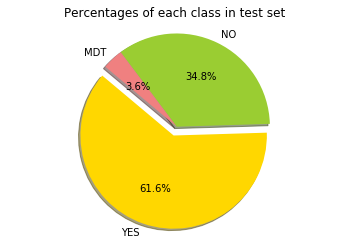

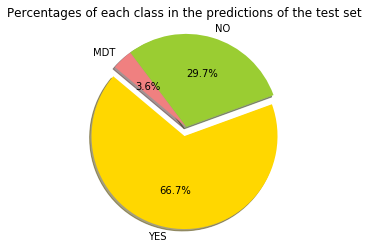

In [12]:
#--------------results evaluation on test set--------------#

#--count the occurence of every class in y predicted and y_test--#
print(collections.Counter(y_test))
print(collections.Counter(pred_test))

def plot_pie_chart(title,perc_1,perc_2,perc_3):

    plt.title(title, fontdict=None, loc='center')
    labels = 'YES', 'NO', 'MDT'
    sizes = [perc_1,perc_2,perc_3]
    colors = ['gold', 'yellowgreen', 'lightcoral']
    explode = (0.1, 0, 0) 
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.show()


plot_pie_chart("Percentages of each class in test set",np.sum(y_test==1),np.sum(y_test==2),np.sum(y_test==3))
plot_pie_chart("Percentages of each class in the predictions of the test set",np.sum(pred_test==1),np.sum(pred_test==2),np.sum(pred_test==3))



In [14]:
def cross_validation(data_array,y_index,k_folds,n,alpha):
    data_c=data
    np.take(data_c,np.random.permutation(data.shape[0]),axis=0,out=data_c)
   
    x=data_c[:,:y_index]
    y=data_c[:,y_index]
    y_unique=np.unique(y)
    x_batch=np.array_split(x,k_folds,axis=0)
    y_batch=np.array_split(y,k_folds,axis=0)

    accuracy_test,accuracy_training,weights=[],[],[]
    for i in range(k_folds):
        x_batch_c,y_batch_c=x_batch,y_batch
        #print(len(y_batch_c))
        x_test=x_batch_c[i]
        y_test=y_batch_c[i]
        
        x_temp=np.delete(x_batch_c, i, 0)
        y_temp=np.delete(y_batch_c, i, 0)
        
        x_train=np.concatenate(x_temp,axis=0)
        y_train=np.concatenate(y_temp,axis=0)
        #print(x_train.shape)
        #print(len(y_train))
        
        
        w=MLR_fit(x_train,y_train,n,alpha)
        weights.append(w)
        #print(w)
        pred_test=predict(x_test,w,y_unique)
        pred_train=predict(x_train,w,y_unique)
        #print("Accuracy of testing set ",i+1,"=", np.mean(pred_test==y_test)*100,"%")
        #print("Accuracy of training set ",i+1,"=", np.mean(pred_train==y_train)*100,"%")
        accuracy_test.append(np.mean(pred_test==y_test)*100)
        accuracy_training.append(np.mean(pred_train==y_train)*100)

        
    
    return (np.mean(accuracy_test)) , (np.mean(accuracy_training)) , (np.mean(weights,axis=0))

acc_test,acc_train,avg_weights=cross_validation(data,45,5,10000,0.0001)
print("Average of training accuracy is ",acc_train,"%")
print("Average of testing accuracy is ",acc_test,"%")
print("average weights list ",avg_weights)

#we can test using these weights


    

    
      

Average of training accuracy is  84.51457859678513 %
Average of testing accuracy is  83.23072040622026 %
average weights list  [[-2.16276894e-01  1.04325768e-02 -1.71415267e-01  6.40458106e-01
  -5.20480156e-03  4.56170741e-02  8.86189244e-02  1.12885796e+00
  -5.92994022e-02 -8.93567820e-01 -3.23788906e+00 -5.34121541e-01
  -1.40219053e+00 -1.43199073e-01  1.51966268e-01  2.13811594e-01
   1.72776167e+00  3.00758378e+00  1.35264334e-01 -2.09129183e-01
   2.47070161e-02 -1.67119061e-01 -8.88256015e-01 -5.38648201e-01
  -2.26335362e-02  1.25853181e+00  1.74640715e+00  8.71003386e-01
  -2.64268149e+00 -3.04021369e+00 -5.06802887e-01  3.23155910e-01
   3.00758378e+00  1.67259391e+00 -1.88887080e+00  2.47121163e-01
  -4.63398056e-01 -7.95163913e-02 -1.36760502e-01 -2.11124773e-01
  -5.15212088e-03  4.02874324e-01 -6.19151218e-01 -1.08728028e+00
   8.71003386e-01]
 [-1.91550563e-02 -3.96166810e-02  2.51355329e-01 -8.75935268e-01
  -3.23015571e-04  2.86307586e-02 -4.86658377e-02 -1.18062823e